Optimised Logreg Model using Hypertuning and K-Folds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Helper Functions

In [2]:
# Define train, predict, and accuracy functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(y, y_hat):
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def gradient_descent(X, y, y_hat):
    m = X.shape[0]
    dw = (1 / m) * np.dot(X.T, (y_hat - y))
    db = (1 / m) * np.sum(y_hat - y)
    return dw, db

def train(X, y, bs, epochs, lr, X_val, y_val):
    n_samples, n_features = X.shape
    w = np.zeros((n_features, 1))
    b = 0
    y = y.reshape(n_samples, 1)
    
    training_loss = []
    validation_f1 = []
    validation_loss = []

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, n_samples, bs):
            X_batch = X[i:i + bs]
            y_batch = y[i:i + bs]
            y_hat = sigmoid(np.dot(X_batch, w) + b)
            dw, db = gradient_descent(X_batch, y_batch, y_hat)
            w -= lr * dw
            b -= lr * db

            epoch_loss += loss(y_batch, y_hat)
        
        epoch_loss /= (n_samples // bs)
        training_loss.append(epoch_loss)

        # Calculate validation F1 score and loss
        y_hat_val = sigmoid(np.dot(X_val, w) + b)
        y_pred_val = (y_hat_val > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_val, average='macro')
        validation_f1.append(f1)
        val_loss = loss(y_val, y_hat_val)
        validation_loss.append(val_loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Training Loss: {epoch_loss:.4f}, Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}')

    return w, b, training_loss, validation_f1, validation_loss

def predict(X, w, b):
    y_hat = sigmoid(np.dot(X, w) + b)
    pred = [1 if i > 0.5 else 0 for i in y_hat]
    return np.array(pred)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

Optimisation Function

In [11]:
# def optimize(X_features, Y_label):
#     epochs = 1000
#     learning_rate_options = [0.001, 0.01, 0.1, 0.2]
#     batch_size_options = [16, 32, 64]
    
#     # Split data into training and validation sets (80/20 split)
#     X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_features, Y_label, test_size=0.2, random_state=42)
    
#     f1_results = []
#     best_w = None
#     best_b = None
#     best_f1 = 0
#     best_params = {}

#     for lr in learning_rate_options:
#         for bs in batch_size_options:
#             w, b, training_loss, validation_f1, validation_loss = train(X_train_split, y_train_split, bs, epochs, lr, X_val_split, y_val_split)
#             y_pred = predict(X_val_split, w, b)
#             f1 = f1_score(y_val_split, y_pred, average='macro')

#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = {'learning_rate': lr, 'batch_size': bs}
#                 best_w = w
#                 best_b = b
            
#             # Store the results
#             f1_results.append((lr, bs, f1))

#     f1_df = pd.DataFrame(f1_results, columns=['Learning Rate', 'Batch Size', 'F1 Score'])

#     # Identify the best hyperparameters
#     best_params_idx = f1_df['F1 Score'].idxmax()
#     best_params = f1_df.iloc[best_params_idx]

#     print(f'Best Hyperparameters: Learning Rate = {best_params["Learning Rate"]}, Batch Size = {best_params["Batch Size"]}, F1 Score = {best_params["F1 Score"]:.4f}')

#     return best_params, f1_df, best_w, best_b




from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score
import pandas as pd

def optimize(X_features, Y_label):
    epochs = 1000
    learning_rate_options = [0.001, 0.01, 0.1, 0.2]
    batch_size_options = [16, 32, 64]
    k = 5  # Number of folds for cross-validation

    f1_results = []
    best_w = None
    best_b = None
    best_f1 = 0
    best_params = {}

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for lr in learning_rate_options:
        for bs in batch_size_options:
            f1_scores = []

            for train_index, val_index in kf.split(X_features):
                X_train_split, X_val_split = X_features[train_index], X_features[val_index]
                y_train_split, y_val_split = Y_label[train_index], Y_label[val_index]
                
                w, b, training_loss, validation_f1, validation_loss = train(X_train_split, y_train_split, bs, epochs, lr, X_val_split, y_val_split)
                y_pred = predict(X_val_split, w, b)
                f1 = f1_score(y_val_split, y_pred, average='macro')
                f1_scores.append(f1)

            avg_f1 = sum(f1_scores) / len(f1_scores)

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = {'learning_rate': lr, 'batch_size': bs}
                best_w = w
                best_b = b
            
            # Store the results
            f1_results.append((lr, bs, avg_f1))

    f1_df = pd.DataFrame(f1_results, columns=['Learning Rate', 'Batch Size', 'F1 Score'])

    # Identify the best hyperparameters
    best_params_idx = f1_df['F1 Score'].idxmax()
    best_params = f1_df.iloc[best_params_idx]

    print(f'Best Hyperparameters: Learning Rate = {best_params["Learning Rate"]}, Batch Size = {best_params["Batch Size"]}, F1 Score = {best_params["F1 Score"]:.4f}')

    return best_params, f1_df, best_w, best_b

# Assuming train and predict functions are defined elsewhere


Load Data + Train Model

In [12]:
# Load your data
data = pd.read_csv("C:/Users/muvil/Documents/Muvil/SUTD/Term 5/50.007 Machine Learning/Project/Data/train_tfidf_features.csv")
X_features = data.drop(['label', 'id'], axis=1).values
Y_label = data['label'].values

# Optimize hyperparameters
best_params, f1_df, best_w, best_b = optimize(X_features, Y_label)

Epoch 0, Training Loss: 0.6888, Validation F1: 0.3852, Validation Loss: 0.6827
Epoch 100, Training Loss: 0.6557, Validation F1: 0.3852, Validation Loss: 0.6613
Epoch 200, Training Loss: 0.6462, Validation F1: 0.3857, Validation Loss: 0.6621
Epoch 300, Training Loss: 0.6377, Validation F1: 0.3911, Validation Loss: 0.6633
Epoch 400, Training Loss: 0.6300, Validation F1: 0.4110, Validation Loss: 0.6647
Epoch 500, Training Loss: 0.6230, Validation F1: 0.4346, Validation Loss: 0.6664
Epoch 600, Training Loss: 0.6167, Validation F1: 0.4585, Validation Loss: 0.6682
Epoch 700, Training Loss: 0.6108, Validation F1: 0.4746, Validation Loss: 0.6701
Epoch 800, Training Loss: 0.6054, Validation F1: 0.4971, Validation Loss: 0.6721
Epoch 900, Training Loss: 0.6004, Validation F1: 0.5136, Validation Loss: 0.6742
Epoch 0, Training Loss: 0.6888, Validation F1: 0.3857, Validation Loss: 0.6826
Epoch 100, Training Loss: 0.6563, Validation F1: 0.3857, Validation Loss: 0.6606
Epoch 200, Training Loss: 0.6470

Save Best Parameters

In [7]:
best_lr = best_params['Learning Rate']
best_bs = best_params['Batch Size']

Graph Plots

In [8]:
def plot_f1_vs_batch_size(f1_df):
    learning_rate_options = f1_df['Learning Rate'].unique()
    plt.figure(figsize=(12, 6))
    for lr in learning_rate_options:
        subset = f1_df[f1_df['Learning Rate'] == lr]
        plt.plot(subset['Batch Size'], subset['F1 Score'], marker='o', label=f'LR: {lr}')
    plt.title('F1 Score vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_f1_vs_learning_rate(f1_df):
    batch_size_options = f1_df['Batch Size'].unique()
    plt.figure(figsize=(12, 6))
    for bs in batch_size_options:
        subset = f1_df[f1_df['Batch Size'] == bs]
        plt.plot(subset['Learning Rate'], subset['F1 Score'], marker='o', label=f'BS: {bs}')
    plt.title('F1 Score vs Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pred_vs_actual(y_val, y_pred):
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(y_val)), y_val, color='blue', alpha=0.6, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted')
    plt.plot(range(len(y_pred)), y_pred, color='red', alpha=0.6)
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Class Label')
    plt.legend()
    plt.show()

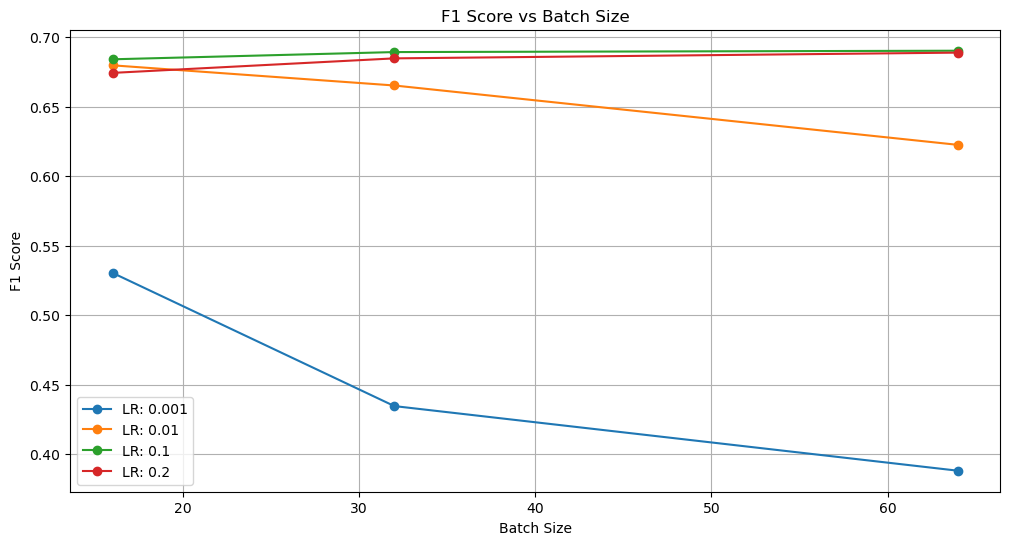

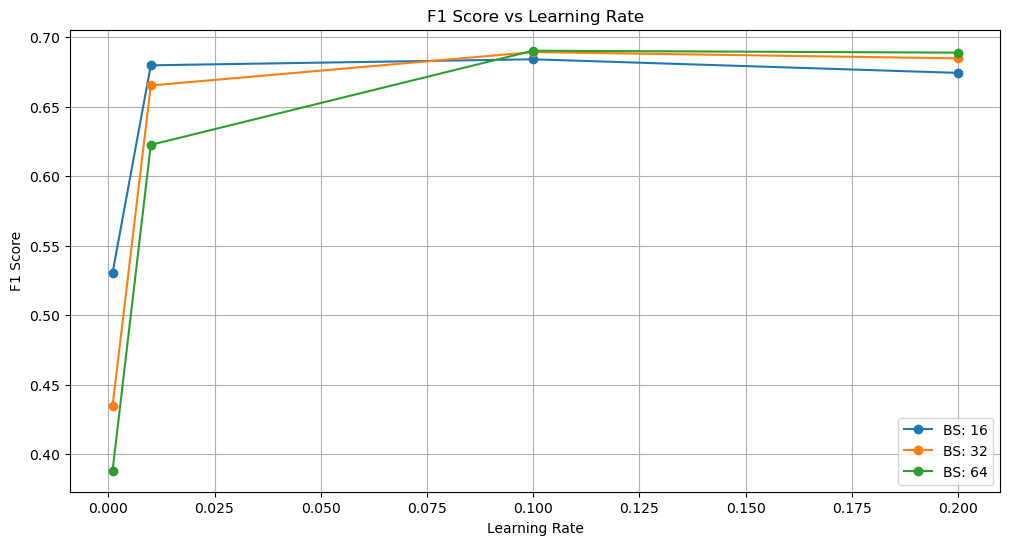

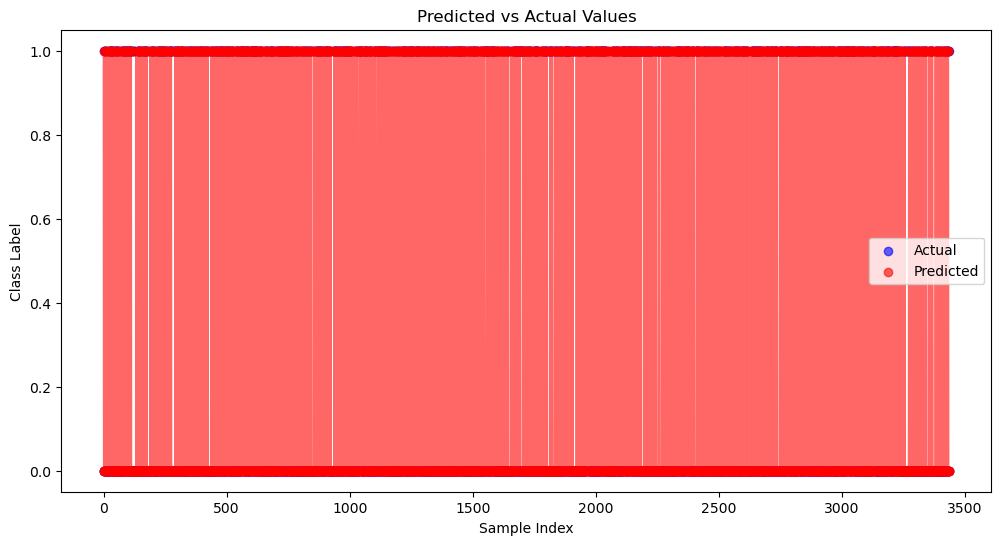

In [9]:
# Plot the results
plot_f1_vs_batch_size(f1_df)
plot_f1_vs_learning_rate(f1_df)

# Validate with the best parameters
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_features, Y_label, test_size=0.2, random_state=42)
y_pred = predict(X_val_split, best_w, best_b)

# Plot predicted vs actual values
plot_pred_vs_actual(y_val_split, y_pred)

Final Test

In [10]:
# Load the test data and first set of predictions
test = pd.read_csv("C:/Users/muvil/Documents/Muvil/SUTD/Term 5/50.007 Machine Learning/Project/Data/test_tfidf_features.csv")

# Predict on the test data using the best model
X_test = test.drop(columns=['id']).values
y_pred_best = predict(X_test, best_w, best_b)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame({
    'id': test['id'],
    'label': y_pred_best
})

# Display the first few rows of the final predictions
print(predictions_df.head())

predictions_df.to_csv('logreg_predictions.csv', index=False)

# Completed Print
print("Final predictions saved to logreg_predictions.csv")

      id  label
0  17185      0
1  17186      0
2  17187      1
3  17188      0
4  17189      0
Final predictions saved to logreg_predictions.csv
